In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from scipy.stats import zscore
from scipy import stats
from tkinter import *

from collections import Counter


import warnings
warnings.filterwarnings("ignore")


In [2]:
def rmse(predictions, targets):
    return np.sqrt(np.mean((predictions-targets)**2))

In [3]:
def model(x, target_df, standard=False, minmax=False, log=False):
    if log:
        #does log work on a bunh of columns at once?
#         x = np.log(x)
        target_df = np.log(target_df)
        
    #split data 
    X_train, X_test, y_train, y_test = train_test_split(x, target_df, random_state=42)
    
    #Implement scaler options if scaler parameters != None
    if minmax:
        scaler = MinMaxScaler()
        scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)
        
    if standard:
        scaler = StandardScaler()
        scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)
        
    #create model
    model = LinearRegression()
    #fit data to model
    model.fit(X_train, y_train)
    
    #Model coef
    df_column_names = x.columns
    coef = pd.DataFrame(list(zip(df_column_names, model.coef_)), columns = ["feature","weight"])\
    .sort_values("weight", ascending=False)
    
    #Make predictions
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    
    if log:
        train_rmse = rmse(np.exp(train_pred), np.exp(y_train.values))
        test_rmse = rmse(np.exp(test_pred), np.exp(y_test.values))
    else:
    
        #train rmse
        train_rmse = rmse(train_pred, y_train.values)
        #test rmse
        test_rmse = rmse(test_pred, y_test.values)

    return ( round(train_rmse,2), round(test_rmse, 2), coef)

# Put best model in get prediction function

In [4]:
def get_prediction(x):
    #create model
    model = LinearRegression()
    #fit best feature df and target to model
    model.fit(all_df, target)
    
    #get prediction for x(user inputs) based off of fitted model
    pred = model.predict(x)
    return pred

In [5]:
def top_entries(df):
    #df.corr().abs().unstack().sort_values(ascending=False).drop_duplicates()
    
    mat = df.corr().abs()
    
    # Remove duplicate and identity entries
    mat.loc[:,:] = np.tril(mat.values, k=-1)
    mat = mat[mat>0]

    # Unstack, sort ascending, and reset the index, so features are in columns
    # instead of indexes (allowing e.g. a pretty print in Jupyter).
    # Also rename these it for good measure.
    return (mat.unstack()
             .sort_values(ascending=False)
             .reset_index()
             .rename(columns={
                 "level_0": "feature_a",
                 "level_1": "feature_b",
                 0: "correlation"
             }))

In [6]:
def click():
    entries = []
    column_names = ["sqft_living", "grade", "sqft_above", "sqft_living15", "bathrooms", "bedrooms", "floors", "sqft_lot15", "sqft_lot", "zipcode", "age"]
    
    #saves text entry to entered_text variable when function is called by button press
    entries.append(sqft_living.get())
    entries.append(grade.get())
    entries.append(sqft_above.get())
    entries.append(sqft_living15.get())
    entries.append(bathrooms.get())
    entries.append(bedrooms.get())
    entries.append(floors.get())
    entries.append(sqft_lot15.get())
    entries.append(sqft_lot.get())
    entries.append(zipcode.get())
    entries.append(age.get())
    
    entries_df = pd.DataFrame([entries], columns= column_names)
    
    #one hot encode zip code column then drop it
    zip_code = entries_df[['zipcode']]
    onehot = OneHotEncoder(sparse=False)
    onehot_data = onehot.fit_transform(zip_code)
    zip_code = pd.DataFrame(onehot_data, columns=onehot.get_feature_names())
    entries_df = pd.concat([entries_df,zip_code],axis=1)
    
    print(entries_df)
#     ##Call model() function at end of this function to get output
#     predicted_price = get_prediction(entries_df)
    
#     if all(item != "" and is_number(item) for item in entries): 
#         #Clear output text box and output new word to it.
#         output.delete(0.0,END)
#         output.insert(END, predicted_price)
#     else:
#         output.delete(0.0,END)
#         output.insert(END, "Error: Missing or Invalid Entries")

In [7]:
def is_number(a):
    # will be True also for 'NaN'
    try:
        number = float(a)
        return True
    except ValueError:
        return False

# import data

In [8]:
path = "../../../data/kc_house_data.csv"

In [9]:
df = pd.read_csv(path)

# Clean the data

### turn columns into floats

In [10]:
df['sqft_living'] = df['sqft_living'].astype(float)
df['bedrooms'] = df['bedrooms'].astype(float)
df['condition'] = df['condition'].astype(float)
df['grade'] = df['grade'].astype(float)
df['sqft_above'] = df['sqft_above'].astype(float)
df['yr_built'] = df['yr_built'].astype(float)
df['zipcode'] = df['zipcode'].astype(float)
df['sqft_living15'] = df['sqft_living15'].astype(float)
df['sqft_lot15'] = df['sqft_lot15'].astype(float)
df['sqft_lot'] = df['sqft_lot'].astype(float)

# Create new columns

In [11]:
df["age"] = df["yr_built"].map(lambda x: 2021 - x)

In [12]:
df["listing_age"] = df["date"].map(lambda date: float(date.split("/")[0]) + (2021- float(date.split("/")[2]) )*12)

### Add zip code(categorical) columns

In [13]:
zip_code = df[['zipcode']]
onehot = OneHotEncoder(sparse=False)
onehot_data = onehot.fit_transform(zip_code)
zip_code = pd.DataFrame(onehot_data, columns=onehot.get_feature_names())
df = pd.concat([df,zip_code],axis=1)

### Add cross product columns

In [14]:
# Top cross correlations via function at head of notebook
top = top_entries(df).dropna()

In [15]:
top = top[top["feature_a"].str.contains("&", "price")==False]
top = top[top["feature_b"].str.contains("&")==False]
top = top[top["feature_b"].str.contains("price")==False]

In [16]:
top[:5]

,feature_a,feature_b,correlation
0,yr_built,age,1.000000
1,sqft_living,sqft_above,0.876448
2,sqft_living,grade,0.762779
3,sqft_living,sqft_living15,0.756402
4,grade,sqft_above,0.756073


In [17]:
df["sqft_living&above"] = df["sqft_living"] * df["sqft_above"]
df["sqft_living&grade"] = df["sqft_living"] * df["grade"]
df["sqft_living&living15"] = df["sqft_living"] * df["sqft_living15"]
df["grade&sqft_above"] = df["grade"] * df["sqft_living"]
df["bathrooms&sqft_living"] = df["bathrooms"] * df["sqft_living"]
df["sqft_above&sqft_living15"] = df["sqft_above"] *df["sqft_living15"]
df["grade&sqft_above"] = df["grade"] * df["sqft_above"]
df["grade&sqft_living15"] = df["grade"] * df["sqft_living15"]
df["grade&sqft_above"] = df["grade"] * df["sqft_above"]

### Drop useless columns

In [18]:
df.drop(["waterfront", "yr_renovated", "view", "lat", 'yr_built', 'date', 'zipcode', 'id', 'sqft_basement'], axis=1, inplace=True)

### Drop na from dataset

In [19]:
df.dropna(inplace=True)

# Eliminate outliers

In [20]:
z_scores = stats.zscore(df[['bedrooms','bathrooms','sqft_living','sqft_lot','floors','grade','sqft_above','sqft_living15','sqft_lot15', "price"]])
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)

In [21]:
df = df[filtered_entries]

# Counter of how many times each unique element appears in categorical columns

In [22]:
Counter(df["age"]);

# Get ascending list of correlations

In [23]:
corrs = df.corr()["price"].sort_values(ascending=False).drop("price")

# Create variable called target that contains price column of full df

In [24]:
target = df["price"]

# Create baseline model

In [25]:
baseline_df = df[[corrs.keys()[0]]]

In [26]:
model(baseline_df, target)[:2]

(182336.01, 179512.61)

# Create model with top 3

In [27]:
top3_df = df[[corrs.keys()[0], corrs.keys()[1], corrs.keys()[2]]]

In [28]:
model(top3_df, target)[:2]

(179316.34, 176645.47)

# Top 7 correlated

In [29]:
top7_df = df[[corrs.keys()[0], corrs.keys()[1], corrs.keys()[2], corrs.keys()[3], corrs.keys()[4], corrs.keys()[5], corrs.keys()[6]]]

In [30]:
model(top7_df, target, standard=True)[:2]

(176326.54, 173843.05)

# All usable columns (zip code and cross multiplications added)

In [31]:
all_df = df.drop(['price', 'long', 'condition'],axis=1)

In [32]:
model(all_df, target)[:2]

(105108.33, 106599.01)

# All with minmax

In [33]:
model(all_df, target, minmax=True)[:2]

(105108.33, 106598.67)

# All with standard

In [34]:
model(all_df, target, standard=True)[:2]

(105109.38, 106598.63)

# All with standard and log

In [35]:
best = model(all_df, target, standard=True, log=True)

In [36]:
best[2]

,feature,weight
7,sqft_living15,1.772778e-01
82,sqft_living&grade,1.421108e-01
6,sqft_above,1.375373e-01
2,sqft_living,1.272301e-01
5,grade,9.410569e-02
...,...,...
37,x0_98042.0,-2.703605e+10
34,x0_98038.0,-2.729639e+10
39,x0_98052.0,-2.748983e+10
60,x0_98115.0,-2.799838e+10


# Price distribution skew

<AxesSubplot:xlabel='price', ylabel='Count'>

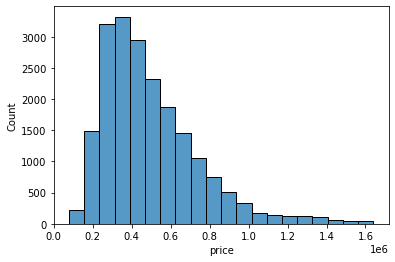

In [37]:
sns.histplot(df.price, bins=20)

# Feature importance

<AxesSubplot:xlabel='feature', ylabel='weight'>

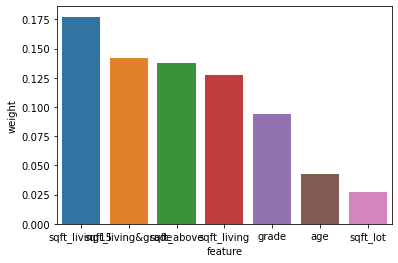

In [38]:
sns.barplot(x=best[2]["feature"][:7], y=best[2]["weight"][:7])

# Bottom of page. Run GUI loop

In [39]:
#neccesary?
columns = df[['bedrooms','bathrooms','sqft_living','sqft_lot','floors','grade','sqft_above','sqft_living15','sqft_lot15','price']]

In [40]:
window = Tk()
window.title("my first")
window.configure(background="blue")

In [41]:
#create header label
Label (window, text="Enter the data:", bg="blue", fg="white", font="none 22 bold") .grid(row=0, column=0, columnspan=2, sticky=W)

In [42]:
#create input labels
input_labels = ['sqft_living', 'grade', 'sqft_above', 'sqft_living15', 'bathrooms', 'bedrooms', 'floors', 'sqft_lot', 'sqft_lot15', 'age', "zipcode"]
i=1
for item in input_labels:
    Label (window, text=item, bg="blue", fg="white", font="none 12 bold") .grid(row=i, column=0, sticky=W)
    i+=1

In [43]:
#create label entry boxes
sqft_living = Entry(window, width=20, bg="white")
sqft_living.grid(row=1, column=1, sticky=W)
grade = Entry(window, width=20, bg="white")
grade.grid(row=2, column=1, sticky=W)
sqft_above = Entry(window, width=20, bg="white")
sqft_above.grid(row=3, column=1, sticky=W)
sqft_living15 = Entry(window, width=20, bg="white")
sqft_living15.grid(row=4, column=1, sticky=W)
bathrooms = Entry(window, width=20, bg="white")
bathrooms.grid(row=5, column=1, sticky=W)
bedrooms = Entry(window, width=20, bg="white")
bedrooms.grid(row=6, column=1, sticky=W)
floors = Entry(window, width=20, bg="white")
floors.grid(row=7, column=1, sticky=W)
sqft_lot = Entry(window, width=20, bg="white")
sqft_lot.grid(row=8, column=1, sticky=W)
sqft_lot15 = Entry(window, width=20, bg="white")
sqft_lot15.grid(row=9, column=1, sticky=W)
age = Entry(window, width=20, bg="white")
age.grid(row=10, column=1, sticky=W)
zipcode = Entry(window, width=20, bg="white")
zipcode.grid(row=11, column=1, sticky=W)

In [44]:
#Add submit button
Button (window, text="SUBMIT", width=6, command=click) .grid(row=len(input_labels)+1,column=0, columnspan=2, sticky=W)

In [45]:
#Add another label
Label (window, text="Predicted Price:", bg="black", fg="white", font="none 20 bold") .grid(row=len(input_labels)+2, column=0,sticky=W)

In [46]:
#text output box
output = Text(window, width=75, height=6, wrap=WORD, background="white")
output.grid(row=len(input_labels)+3, column=0, columnspan=2, sticky=W)

In [47]:
#Run gui loop
window.mainloop()

  sqft_living grade sqft_above sqft_living15 bathrooms bedrooms floors  \
0                                                    e                   

  sqft_lot15 sqft_lot zipcode age  x0_  
0                                  1.0  
